## Playing w/ basis expansion

As I read basis expansion notebook, I will try to follow along solving my own problem.

Intuitively it seems a basis expansion is a great approac.  I may need to return to course notes to undestand it.


So...  new plan...  

1. Excel: Prepare files (book keeping - machine readable)
    * prepare metadata into comments column
    * reduce set of columns
    * filter to keys
    * export keys
    
    
2. Python: Generate DTW matches (dtw - similarity score)
    * generate DTW matched keys
        * include welds
        * my data vector
        * my weights
    * output key matches
    
    
3. Excel: Generate RMM points (book keeping - physical changes)
    * break matches to achieve smoothness
        * automatic if bad matches removed?
        * address physical changes (reroutes and repairs)
    * export rmm points
    
    
4. Python: Generate DTW matches (trimming, fitting, predicting)
    * 2nd ord diff
        * here or before export (acelleration of change)
    * generate correction curve
        * learn knot locations (???)
        * fit cubic spline (basis projection)
    * generate DTW matched features
        * do not include depth
        * heavy weight on distance from correction curve
        * radial position as discrete increments
    * output feature matches
    
    
5. Excel/Python: Trim outliers (trimming, review)
    * review matches
    * remove bad matches
        * is diff vis a vis correction curve still in play?
        * retain clusters and best match (match score)
    * compare vs ground truth
    * report
    
    
#### Only outstanding question...  knot locations




### Dependencies

Will only add them as I understand them

In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from basis_expansions import LinearSpline
from basis_expansions import CubicSpline


%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Import data from csv to a data frame
* possible to do this in chunks?
    * appears to work for textFileReader...
    * will it also work for numbers?

In [2]:
#df = pd.read_csv('../data-sctdj-64 rows-2 col.csv', skiprows=2, header=0, names=['wc','rmm'], dtype={'wc':np.float_,'rmm':np.float_})
dfi = pd.read_csv('../data-sctdj-357 rows-2 col.csv', skiprows=2, header=0, names=['wc','rmm'], dtype={'wc':np.float_,'rmm':np.float_})


dfi.head()

,wc,rmm
0,7519.87,-4.51
1,7557.14,-4.55
2,7594.39,-4.61
3,7631.70,-4.60
4,7668.95,-4.63


In [47]:
#df.applymap(lambda x: x/(range(x)))
#(df-df.mean())/df.std()  # not on interval [0,1]
df=(dfi-dfi.min())/(dfi.max()-dfi.min())
df['wc']

0      0.000000
1      0.002988
2      0.005974
3      0.008965
4      0.011951
         ...   
352    0.990842
353    0.991665
354    0.992756
355    0.996375
356    1.000000
Name: wc, Length: 357, dtype: float64

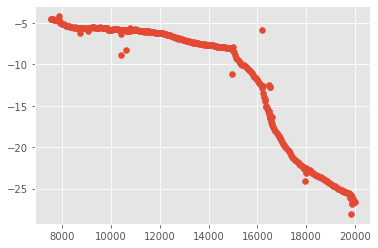

In [35]:
plt.scatter(dfi['wc'], dfi['rmm'])


In [3]:
xy=df.to_numpy()

#x = np.array(range(0,64))
x = xy[:,0]
y = xy[:,1]
#x.reshape(-1, 1)

#plt.scatter(x, y)

NameError: name 'df' is not defined

In [93]:
def make_pl_regression(n_knots):
    return Pipeline([
        ('pl', LinearSpline(0, 1, n_knots=n_knots)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

regression = make_pl_regression(3)
regression.fit(x,y)
# scale data to bet 0 and 1

# 1. figure out how to move knot locations
# 2. can I do this without scaling to [0,1]
# 3. can i access the line equations for interpolation

# 4. can i use x-axis irregular spacing 
#.       A: yes, already doing this

# 5. fit whole curve by minimizing error over arbitrary number of knots?
#.    grad descent or something?  num knots w/ least error

Pipeline(steps=[('pl',
                 LinearSpline(knots=array([0.75, 0.5 , 0.25]), max=0, min=1,
                              n_knots=3, n_params=4)),
                ('regression', LinearRegression())])

In [94]:
regressions = {}
for n_knots in range(2, 25):
    regressions[n_knots] = make_pl_regression(n_knots)
    regressions[n_knots].fit(x.reshape(-1, 1), y)
    #regressions[n_knots].fit(x.reshape(-1, 1), y)

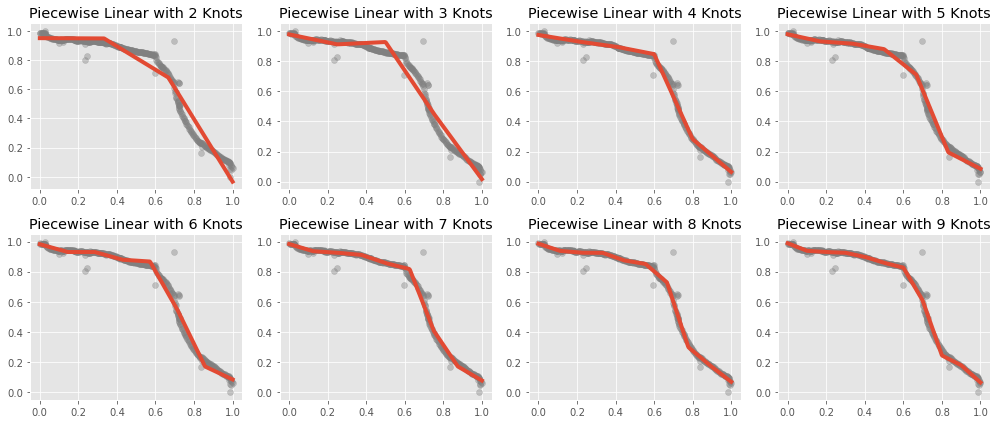

In [95]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6))

t = np.linspace(0, 1, 250)
for i, ax in enumerate(ax.flatten()):
    n_knots = i + 2
    ax.plot(t, regressions[n_knots].predict(t.reshape(-1, 1)), linewidth=4)
    ax.scatter(x, y, alpha=0.4, color="grey")
    ax.set_title("Piecewise Linear with {} Knots".format(n_knots))
    
fig.tight_layout()

In [96]:
def make_pw_cubic_regression(n_knots):
    return Pipeline([
        ('pw_cubic', CubicSpline(0, 1, n_knots=n_knots)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

regressions = {}
for n_knots in range(2, 25):
    regressions[n_knots] = make_pw_cubic_regression(n_knots)
    regressions[n_knots].fit(x.reshape(-1, 1), y)

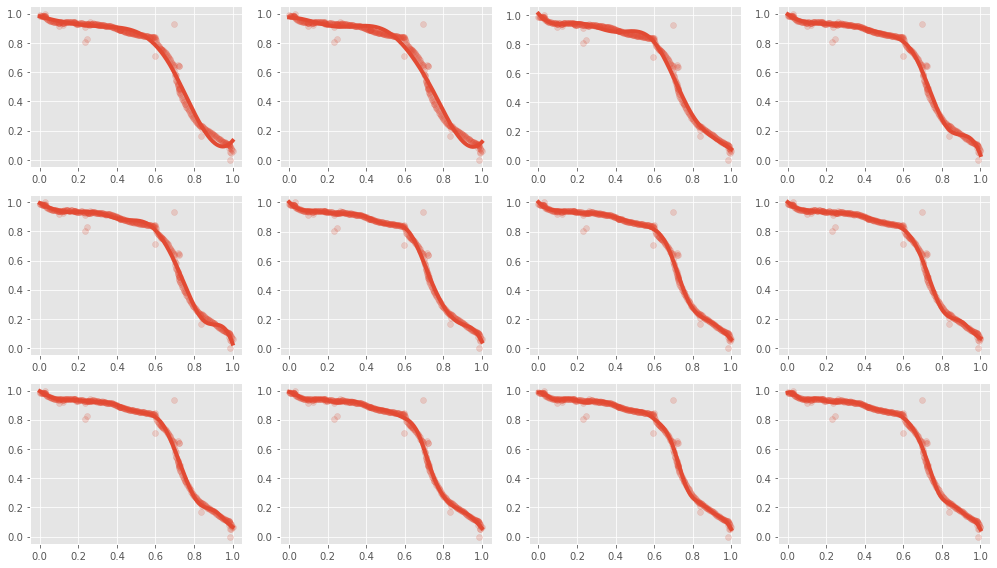

In [97]:
fig, ax = plt.subplots(3, 4, figsize=(14, 8))

t = np.linspace(0, 1, 250)
for i, ax in enumerate(ax.flatten()):
    n_knots = i + 2
    ax.plot(t, regressions[n_knots].predict(t.reshape(-1, 1)), linewidth=4)
    ax.scatter(x, y, alpha=0.2)


    
fig.tight_layout()

# looks good, but how would I interpolate?

In [5]:
knot = pd.read_csv('../data-sctdj-357 rows-2 col - 25 knots.csv', skiprows=2, header=0, names=['loc'], dtype={'loc':np.float_})
knot.head()



,loc
0,0.0000
1,0.0320
2,0.0393
3,0.0683
4,0.0980


In [18]:
knot.dtypes

loc    float64
dtype: object

In [6]:
knotty=knot.to_numpy()

#x = np.array(range(0,64))
# x = xy[:,0]
# y = xy[:,1]

In [21]:
regression = Pipeline([
        ('pl', LinearSpline(min=0, max=1, knots=knotty)),
        ('regression', LinearRegression(fit_intercept=True))
    ])
regression.fit(x,y)

Pipeline(steps=[('pl',
                 LinearSpline(knots=array([[0.    ],
       [0.032 ],
       [0.0393],
       [0.0683],
       [0.098 ],
       [0.1877],
       [0.1948],
       [0.2202],
       [0.2611],
       [0.285 ],
       [0.3693],
       [0.4678],
       [0.5996],
       [9.6157],
       [0.67  ],
       [0.6967],
       [0.722 ],
       [0.7353],
       [0.7934],
       [0.8224],
       [0.8401],
       [0.8473],
       [0.8582],
       [0.9345],
       [0.9836],
       [1.    ]]),
                              max=1, min=0, n_knots=26, n_params=27)),
                ('regression', LinearRegression())])

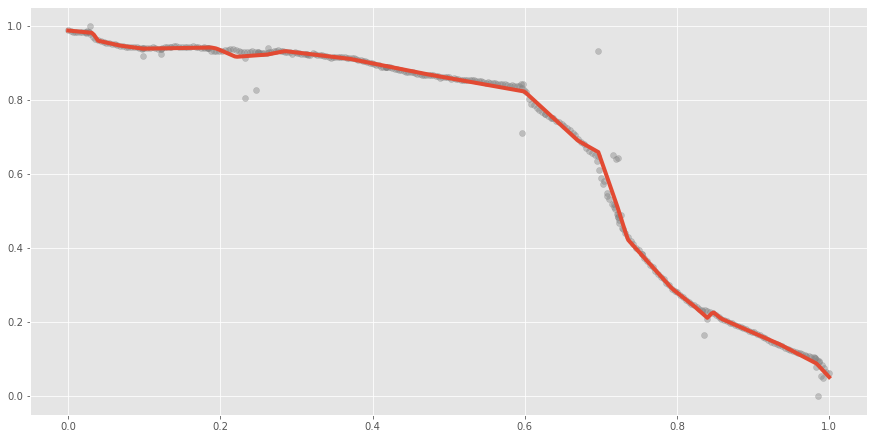

In [25]:
# fig, ax = plt.subplots(2, 4, figsize=(14, 6))

t = np.linspace(0, 1, 357)
# for i, ax in enumerate(ax.flatten()):
# n_knots = i + 2
plt.figure(figsize=[15,7.5]);
plt.plot(t, regression.predict(t.reshape(-1, 1)), linewidth=4)
plt.scatter(x, y, alpha=0.4, color="grey")
#. ax.set_title("Piecewise Linear with {} Knots".format(n_knots))
    
# fig.tight_layout()

## Thinking

* need to access these lines
* need to pick better knot locations
* turn off axis scaling `  ('pl', LinearSpline(min=0, max=1, knots=knotty)),`
* 

In [29]:
regression.predict([0.5])

array([0.85856012])

It worked!!

I just did a reverse lookup against the regression!


## Try cubic spline

In [7]:
# Scale knots to full spread of data
# df=(dfi-dfi.min())/(dfi.max()-dfi.min())
xy=dfi.to_numpy()

#x = np.array(range(0,64))
x = xy[:,0]
y = xy[:,1]

knot2 = knot*(x.max()-x.min())+x.min()
knot2

,loc
0,7519.870000
1,7919.054320
2,8010.118243
3,8371.879033
4,8742.371980
5,9861.335527
6,9949.904548
7,10266.757102
8,10776.964561
9,11075.105350


In [14]:
print(x.min)
print(x.max)
snotty = knot2.to_numpy()
print(type(snotty))

<built-in method min of numpy.ndarray object at 0x7fd6f0436030>
<built-in method max of numpy.ndarray object at 0x7fd6f0436030>
<class 'numpy.ndarray'>


In [8]:
#t = np.linspace(14500, 17000, num=250)


cregression = Pipeline([
        ('pw_cubic', CubicSpline(x.min, x.max, knots=snotty)),
        ('regression', LinearRegression(fit_intercept=True))])

cregression.fit(x,y)

Pipeline(steps=[('pw_cubic',
                 CubicSpline(knots=array([[  7519.87    ],
       [  7919.05432 ],
       [  8010.118243],
       [  8371.879033],
       [  8742.37198 ],
       [  9861.335527],
       [  9949.904548],
       [ 10266.757102],
       [ 10776.964561],
       [ 11075.10535 ],
       [ 12126.706543],
       [ 13355.445778],
       [ 14999.586196],
       [127471.015807],
       [ 15877.7917  ],
       [ 16210.861117],
       [ 16526.46622 ],
       [ 16692.377203],
       [ 17417.146234],
       [ 17778.907024],
       [ 17999.705851],
       [ 18089.522323],
       [ 18225.494482],
       [ 19177.299595],
       [ 19789.798036],
       [ 19994.38    ]]),
                             max=<built-in method min of numpy.ndarray object at 0x7fd6f0436030>,
                             min=<built-in method max of numpy.ndarray object at 0x7fd6f0436030>,
                             n_knots=26, n_params=29)),
                ('regression', LinearRegression())])

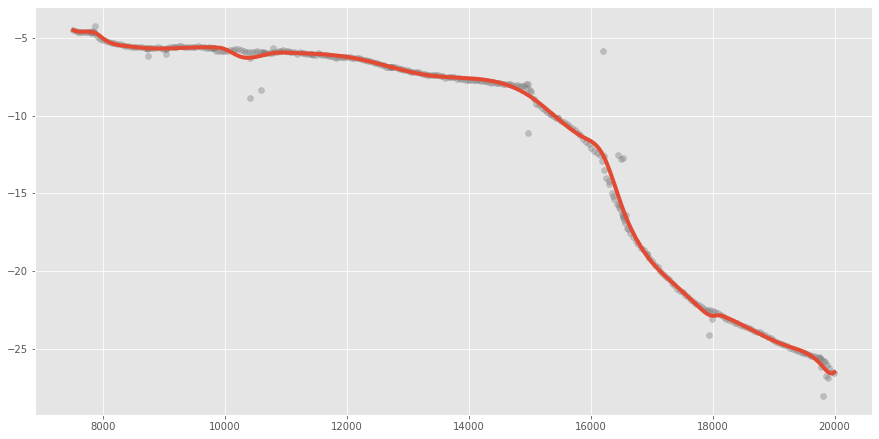

In [54]:
t = np.linspace(x.min(), x.max(), x.size)

plt.figure(figsize=[15,7.5]);
plt.plot(t, cregression.predict(t.reshape(-1, 1)), linewidth=4)
plt.scatter(x, y, alpha=0.4, color="grey")

In [58]:
cregression.predict([16000])

array([-11.63743319])

### Observations...

* need to trim to 1x std dev off 2nd order diff before fitting curve
* knot location matters
* cubic splines kck ass if I can get predicted values, which I can!